# Modular CerberusTS Experimentation

In [1]:
import os
os.chdir("..")

In [2]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator
from cerberus_ts import Foresight, train_foresight

import pandas as pd

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]

In [4]:
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

window_sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)   
}

In [5]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 1000)

# Prepare the data
preparer.prepare_data()

In [6]:
foresight = Foresight(sizes,feature_indexes)

In [7]:
#foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 3)

In [8]:
model = Cerberus(sizes, feature_indexes)

In [9]:
model = train_cerberus(model, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.0012959082463445764
Epoch [2/60], Loss: 0.0009874643267054732
Epoch [3/60], Loss: 0.0008828196705629428
Epoch [4/60], Loss: 0.0008495605527423322
Epoch [5/60], Loss: 0.0008260061910065512
Epoch [6/60], Loss: 0.0007920416361109043
Epoch [7/60], Loss: 0.0007723333620621512
Epoch [8/60], Loss: 0.0007491855094364534
Epoch [9/60], Loss: 0.0007255971798440442
Epoch [10/60], Loss: 0.0007064992608502508
Epoch [11/60], Loss: 0.0006786149808128053
Epoch [12/60], Loss: 0.0006461835640948266
Epoch [13/60], Loss: 0.0006143124942900612
Epoch [14/60], Loss: 0.000587244361716633
Epoch [15/60], Loss: 0.0005548516499887531
Epoch [16/60], Loss: 0.0005216032652727639
Epoch [17/60], Loss: 0.00048610754097656655
Epoch [18/60], Loss: 0.00045358185200408723
Epoch [19/60], Loss: 0.0004167889111946958
Epoch [20/60], Loss: 0.00040540469858873015
Epoch [21/60], Loss: 0.00036312976046853386
Epoch [22/60], Loss: 0.00033037694044954453
Epoch [23/60], Loss: 0.00033313846322319783
Epoch [24/60], 

          0         1         2
0  0.887289  0.656117  0.822978
1  0.885841  0.662276  0.806869
2  0.884788  0.665463  0.794548
3  0.883659  0.665699  0.784899
4  0.882940  0.669743  0.782293
5  0.882587  0.672260  0.769247
6  0.882671  0.670965  0.760585
7  0.883541  0.673324  0.761541
8  0.883274  0.679088  0.750664


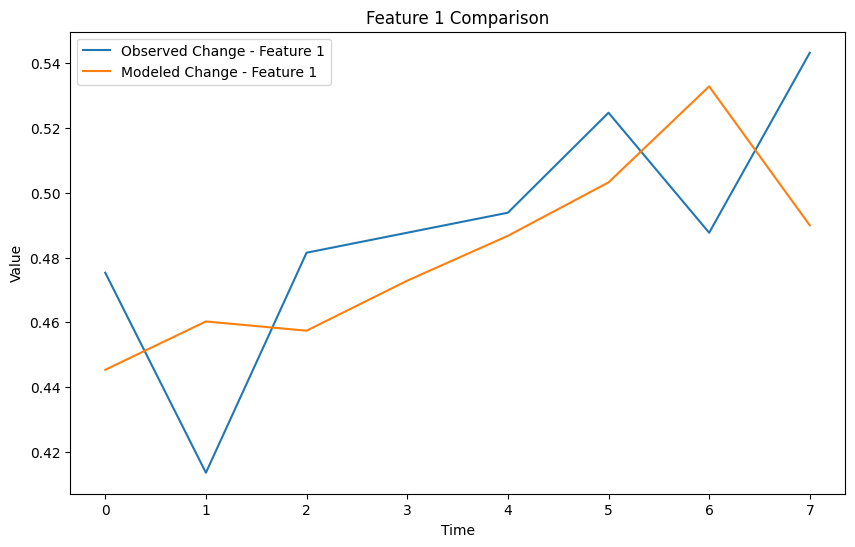

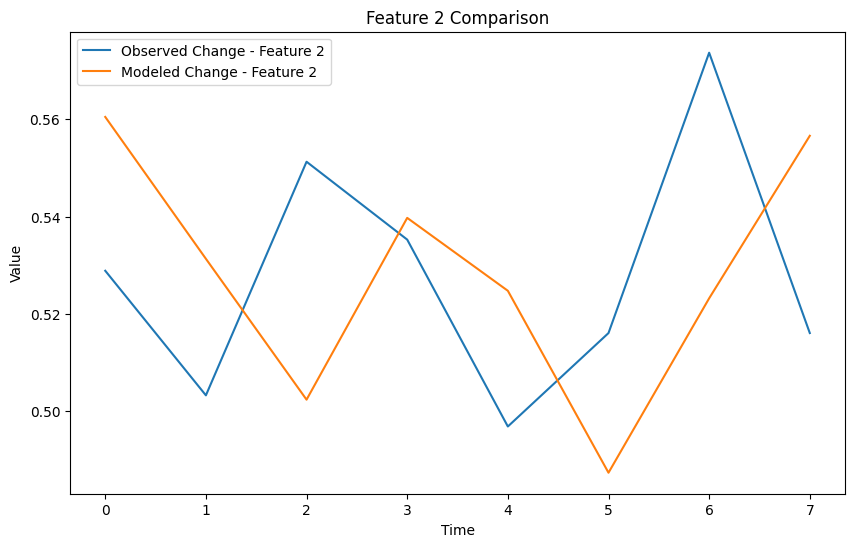

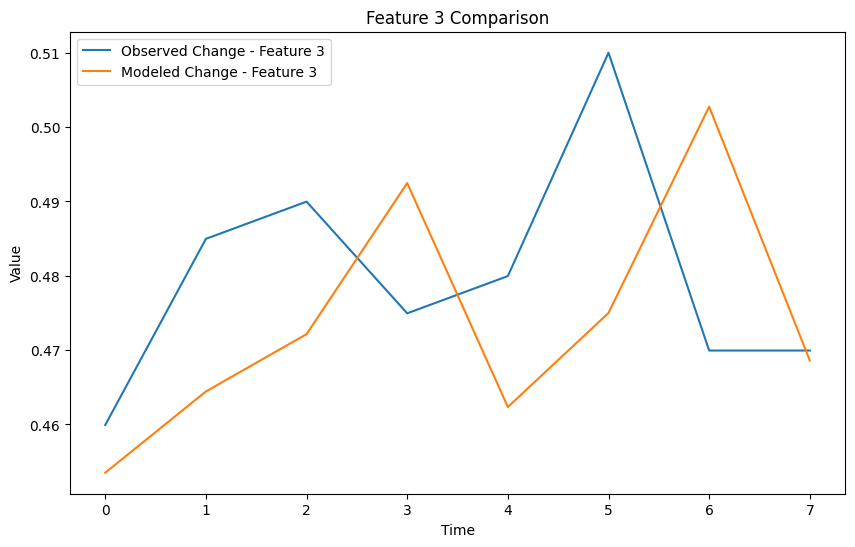

In [25]:
# Intialize Response Generator
generator = ResponseGenerator(model, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 3
generator.generate_response(sel_index)

print(generator.denormalized_response)
generator.plot_normalized_responses()

In [47]:
iterators = [iter(dataloader) for dataloader in preparer.dataloaders]
batches = [next(iterator) for iterator in iterators]
responses_batch = next(batch[2] for batch in batches)
print(responses_batch[0,0,:,:])
print(responses_batch[0,1,:,:])

tensor([[0.5432, 0.5160, 0.4950],
        [0.5000, 0.5288, 0.5251],
        [0.5062, 0.5096, 0.4800],
        [0.5556, 0.5321, 0.6152],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], device='cuda:0')
tensor([[0.4568, 0.4840, 0.5050],
        [0.5000, 0.4712, 0.4749],
        [0.4938, 0.4904, 0.5200],
        [0.4444, 0.4679, 0.3848],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], device='cuda:0')


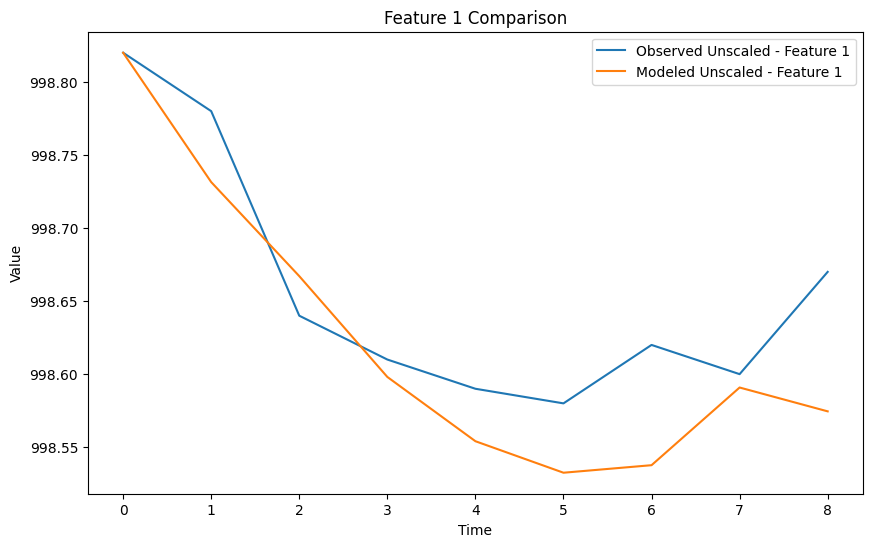

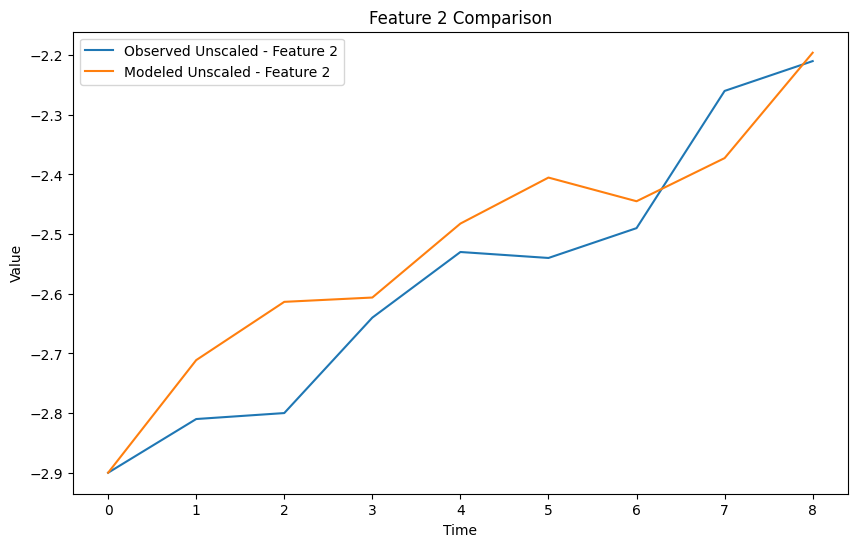

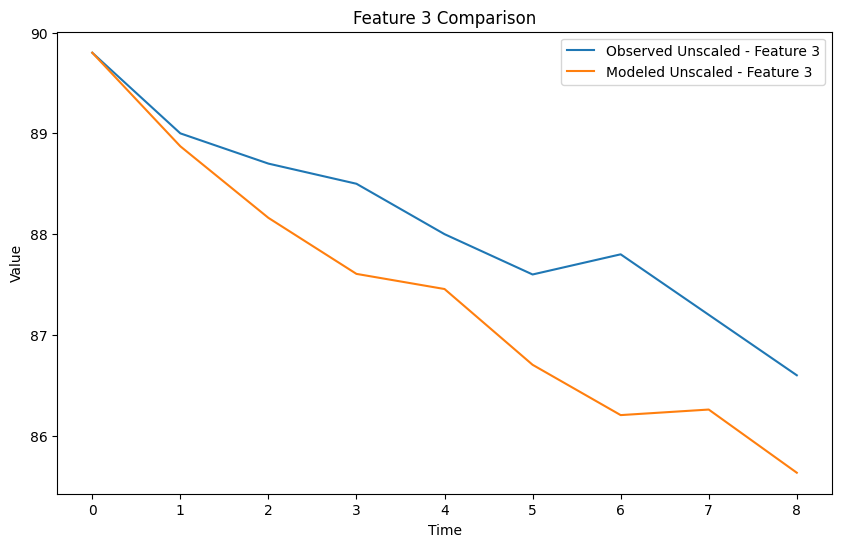

In [26]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)